In [1]:
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import spacy

from collections import Counter
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, Phrases
from tqdm import tqdm
from wordcloud import WordCloud

In [2]:
data_path = '../../data'

# Listings

In [3]:
listings = pd.read_json(os.path.join(data_path, 'airbnb_listings.json'))
listings = listings.drop_duplicates(subset='id')
listings

id  property_type_id  tier_id  \
0     13301630               2.0        0   
1     46026275              37.0        0   
2     35774873              37.0        0   
3      8174032               1.0        0   
4     20881330              53.0        0   
...        ...               ...      ...   
7315  42172804              37.0        0   
7316  21040786              38.0        0   
7317  31581094               2.0        0   
7318  18426407               2.0        0   
7319  43486316              37.0        0   

                                                   name  bedrooms  beds  \
0          2 Beds in my San Diego Master Bedroom Suite.       1.0   1.0   
1           Simple Bedroom + Private bathroom + parking       1.0   1.0   
2     PERFECT STUDIO-DOWNTOWN LITTLE ITALY&PARKING SPOT       0.0   1.0   
3                            Vacant bed for short stays       1.0   1.0   
4           Beautiful Studio in the Heart of San Diego!       0.0   1.0   
...                                                 ...       ...   ...   
7315                 Cozy Downtown Loft in a High-Rise!       0.0   1.0   
7316  VOTED "BEST VIEW" - entire home - central loca...       2.0   6.0   
7317                                 The Alfred Mansion       5.0   8.0   
7318      Charming Hillcrest/Mission Hills 3 BR + House       3.0   4.0   
7319                                          Dream Zen       0.0   1.0   

      bathrooms bedroom_label  bathroom_label  person_capacity  ...  \
0           1.0     1 bedroom   1 shared bath                5  ...   
1           1.0     1 bedroom  1 private bath                2  ...   
2           1.0        Studio          1 bath                2  ...   
3           1.0     1 bedroom          1 bath                1  ...   
4           1.0        Studio          1 bath                2  ...   
...         ...           ...             ...              ...  ...   
7315        1.0        Studio          1 bath                2  ...   
7316        2.0    2 bedrooms         2 baths               10  ...   
7317        4.5    5 bedrooms       4.5 baths               12  ...   
7318        2.0    3 bedrooms         2 baths                8  ...   
7319        1.0        Studio          1 bath                3  ...   

     is_new_listing       room_and_property_type  room_type_category  \
0             False        Private room in house        private_room   
1              True  Private room in condominium        private_room   
2             False           Entire condominium         entire_home   
3             False    Private room in apartment        private_room   
4             False           Entire guest suite         entire_home   
...             ...                          ...                 ...   
7315          False           Entire condominium         entire_home   
7316          False              Entire bungalow         entire_home   
7317          False                 Entire house         entire_home   
7318          False                 Entire house         entire_home   
7319          False           Entire condominium         entire_home   

            room_type          space_type  \
0        Private room        Private room   
1        Private room        Private room   
2     Entire home/apt  Entire condominium   
3        Private room        Private room   
4     Entire home/apt  Entire guest suite   
...               ...                 ...   
7315  Entire home/apt  Entire condominium   
7316  Entire home/apt     Entire bungalow   
7317  Entire home/apt        Entire house   
7318  Entire home/apt        Entire house   
7319  Entire home/apt  Entire condominium   

                                preview_amenity_names  \
0     [Wifi, Free parking, Kitchen, Air conditioning]   
1     [Wifi, Free parking, Kitchen, Air conditioning]   
2     [Wifi, Free parking, Kitchen, Air conditioning]   
3                                     [Wifi, Kitchen]   
4     [Wifi, Free parking,

In [4]:
listings = listings[listings.neighborhood.notna()]
listings

id  property_type_id  tier_id  \
1     46026275              37.0        0   
2     35774873              37.0        0   
3      8174032               1.0        0   
4     20881330              53.0        0   
5     12855271              40.0        0   
...        ...               ...      ...   
7315  42172804              37.0        0   
7316  21040786              38.0        0   
7317  31581094               2.0        0   
7318  18426407               2.0        0   
7319  43486316              37.0        0   

                                                   name  bedrooms  beds  \
1           Simple Bedroom + Private bathroom + parking       1.0   1.0   
2     PERFECT STUDIO-DOWNTOWN LITTLE ITALY&PARKING SPOT       0.0   1.0   
3                            Vacant bed for short stays       1.0   1.0   
4           Beautiful Studio in the Heart of San Diego!       0.0   1.0   
5      #4  UNIT #4 +A/C+Jacuzzi/self check-in after 4pm       1.0   2.0   
...                                                 ...       ...   ...   
7315                 Cozy Downtown Loft in a High-Rise!       0.0   1.0   
7316  VOTED "BEST VIEW" - entire home - central loca...       2.0   6.0   
7317                                 The Alfred Mansion       5.0   8.0   
7318      Charming Hillcrest/Mission Hills 3 BR + House       3.0   4.0   
7319                                          Dream Zen       0.0   1.0   

      bathrooms bedroom_label  bathroom_label  person_capacity  ...  \
1           1.0     1 bedroom  1 private bath                2  ...   
2           1.0        Studio          1 bath                2  ...   
3           1.0     1 bedroom          1 bath                1  ...   
4           1.0        Studio          1 bath                2  ...   
5           1.0     1 bedroom          1 bath                4  ...   
...         ...           ...             ...              ...  ...   
7315        1.0        Studio          1 bath                2  ...   
7316        2.0    2 bedrooms         2 baths               10  ...   
7317        4.5    5 bedrooms       4.5 baths               12  ...   
7318        2.0    3 bedrooms         2 baths                8  ...   
7319        1.0        Studio          1 bath                3  ...   

     is_new_listing       room_and_property_type  room_type_category  \
1              True  Private room in condominium        private_room   
2             False           Entire condominium         entire_home   
3             False    Private room in apartment        private_room   
4             False           Entire guest suite         entire_home   
5             False            Entire guesthouse         entire_home   
...             ...                          ...                 ...   
7315          False           Entire condominium         entire_home   
7316          False              Entire bungalow         entire_home   
7317          False                 Entire house         entire_home   
7318          False                 Entire house         entire_home   
7319          False           Entire condominium         entire_home   

            room_type          space_type  \
1        Private room        Private room   
2     Entire home/apt  Entire condominium   
3        Private room        Private room   
4     Entire home/apt  Entire guest suite   
5     Entire home/apt   Entire guesthouse   
...               ...                 ...   
7315  Entire home/apt  Entire condominium   
7316  Entire home/apt     Entire bungalow   
7317  Entire home/apt        Entire house   
7318  Entire home/apt        Entire house   
7319  Entire home/apt  Entire condominium   

                                preview_amenity_names  \
1     [Wifi, Free parking, Kitchen, Air conditioning]   
2     [Wifi, Free parking, Kitchen, Air conditioning]   
3                                     [Wifi, Kitchen]   
4     [Wifi, Free parking, Kitchen, Air conditioning]   
5                         

# Reviews

In [5]:
reviews = pd.read_json(os.path.join(data_path, 'airbnb_reviews.json'))
reviews = reviews.drop_duplicates(subset='id')
reviews

id  listing_id  author_id  recipient_id  rating  \
0       653954608    13301630  328321073      40442827       5   
1       629997649    13301630  328321073      40442827       5   
2       583538843    13301630   31735215      40442827       5   
3       318521505    13301630  212339508      40442827       5   
4       295091676    13301630  124868001      40442827       5   
...           ...         ...        ...           ...     ...   
426202  426354473    28319097   18324884       3808442       5   
426203  402227519    28319097   46016736       3808442       3   
426204  366547778    28319097   74203189       3808442       5   
426205  365733179    28319097  120325436       3808442       5   
426206  406197932    28319097   34872291       3808442       5   

                                                 comments  \
0                                             magnificent   
1       I have been Garry's guest for the last 6 month...   
2       Gary is a wonderful host.\nHe is very nice and...   
3       Recommended to all for a cozy place with great...   
4       Gary was very friendly and welcoming! And the ...   
...                                                   ...   
426202  I had a great stay, the house was super clean,...   
426203  Location is great and host is wonderful.\nRoom...   
426204  Very calm and relaxing room and located at a c...   
426205  As beautiful as shown in the photos! Cute yard...   
426206  Very nice room! The community is very safe and...   

                      created_at response  
0      2020-08-20 22:48:25+00:00      NaN  
1      2020-06-15 23:46:10+00:00      NaN  
2      2019-12-29 00:59:02+00:00      NaN  
3      2018-09-03 22:56:57+00:00      NaN  
4      2018-07-22 23:49:03+00:00      NaN  
...                          ...      ...  
426202 2019-03-20 22:27:36+00:00      NaN  
426203 2019-01-17 23:23:48+00:00      NaN  
426204 2019-01-02 23:41:15+00:00      NaN  
426205 2019-01-01 21:10:33+00:00      NaN  
426206 2019-01-28 21:30:02+00:00      NaN  

[426207 rows x 8 columns]

In [6]:
reviews = reviews[reviews.comments.notna()]
reviews

id  listing_id  author_id  recipient_id  rating  \
0       653954608    13301630  328321073      40442827       5   
1       629997649    13301630  328321073      40442827       5   
2       583538843    13301630   31735215      40442827       5   
3       318521505    13301630  212339508      40442827       5   
4       295091676    13301630  124868001      40442827       5   
...           ...         ...        ...           ...     ...   
426202  426354473    28319097   18324884       3808442       5   
426203  402227519    28319097   46016736       3808442       3   
426204  366547778    28319097   74203189       3808442       5   
426205  365733179    28319097  120325436       3808442       5   
426206  406197932    28319097   34872291       3808442       5   

                                                 comments  \
0                                             magnificent   
1       I have been Garry's guest for the last 6 month...   
2       Gary is a wonderful host.\nHe is very nice and...   
3       Recommended to all for a cozy place with great...   
4       Gary was very friendly and welcoming! And the ...   
...                                                   ...   
426202  I had a great stay, the house was super clean,...   
426203  Location is great and host is wonderful.\nRoom...   
426204  Very calm and relaxing room and located at a c...   
426205  As beautiful as shown in the photos! Cute yard...   
426206  Very nice room! The community is very safe and...   

                      created_at response  
0      2020-08-20 22:48:25+00:00      NaN  
1      2020-06-15 23:46:10+00:00      NaN  
2      2019-12-29 00:59:02+00:00      NaN  
3      2018-09-03 22:56:57+00:00      NaN  
4      2018-07-22 23:49:03+00:00      NaN  
...                          ...      ...  
426202 2019-03-20 22:27:36+00:00      NaN  
426203 2019-01-17 23:23:48+00:00      NaN  
426204 2019-01-02 23:41:15+00:00      NaN  
426205 2019-01-01 21:10:33+00:00      NaN  
426206 2019-01-28 21:30:02+00:00      NaN  

[425977 rows x 8 columns]

In [7]:
automated_review = reviews.comments.apply(lambda x: 'This is an automated posting.' in x)
reviews = reviews[~automated_review]
reviews

id  listing_id  author_id  recipient_id  rating  \
0       653954608    13301630  328321073      40442827       5   
1       629997649    13301630  328321073      40442827       5   
2       583538843    13301630   31735215      40442827       5   
3       318521505    13301630  212339508      40442827       5   
4       295091676    13301630  124868001      40442827       5   
...           ...         ...        ...           ...     ...   
426202  426354473    28319097   18324884       3808442       5   
426203  402227519    28319097   46016736       3808442       3   
426204  366547778    28319097   74203189       3808442       5   
426205  365733179    28319097  120325436       3808442       5   
426206  406197932    28319097   34872291       3808442       5   

                                                 comments  \
0                                             magnificent   
1       I have been Garry's guest for the last 6 month...   
2       Gary is a wonderful host.\nHe is very nice and...   
3       Recommended to all for a cozy place with great...   
4       Gary was very friendly and welcoming! And the ...   
...                                                   ...   
426202  I had a great stay, the house was super clean,...   
426203  Location is great and host is wonderful.\nRoom...   
426204  Very calm and relaxing room and located at a c...   
426205  As beautiful as shown in the photos! Cute yard...   
426206  Very nice room! The community is very safe and...   

                      created_at response  
0      2020-08-20 22:48:25+00:00      NaN  
1      2020-06-15 23:46:10+00:00      NaN  
2      2019-12-29 00:59:02+00:00      NaN  
3      2018-09-03 22:56:57+00:00      NaN  
4      2018-07-22 23:49:03+00:00      NaN  
...                          ...      ...  
426202 2019-03-20 22:27:36+00:00      NaN  
426203 2019-01-17 23:23:48+00:00      NaN  
426204 2019-01-02 23:41:15+00:00      NaN  
426205 2019-01-01 21:10:33+00:00      NaN  
426206 2019-01-28 21:30:02+00:00      NaN  

[424804 rows x 8 columns]

# Merge Data

In [8]:
df = listings[['id', 'neighborhood']].copy()
df = df.merge(reviews[['listing_id', 'comments', 'rating']], left_on='id', right_on='listing_id')
df

id                         neighborhood  listing_id  \
0       35774873  [Core-Columbia, Downtown San Diego]    35774873   
1       35774873  [Core-Columbia, Downtown San Diego]    35774873   
2       35774873  [Core-Columbia, Downtown San Diego]    35774873   
3       35774873  [Core-Columbia, Downtown San Diego]    35774873   
4       35774873  [Core-Columbia, Downtown San Diego]    35774873   
...          ...                                  ...         ...   
366927  43486316                          [Hillcrest]    43486316   
366928  43486316                          [Hillcrest]    43486316   
366929  43486316                          [Hillcrest]    43486316   
366930  43486316                          [Hillcrest]    43486316   
366931  43486316                          [Hillcrest]    43486316   

                                                 comments  rating  
0       Loved staying in this adorable Studio in the h...       5  
1       Brookes studio was in perfect location, right ...       5  
2       This studio is perfect! It has everything you ...       5  
3       Brooke is a great host! So kind and helpful an...       5  
4       Brooke is the epitome of the hostess with the ...       5  
...                                                   ...     ...  
366927  Wonderful place close to great amenities! The ...       5  
366928  Rick is an AMAZING host.  The place is so clos...       5  
366929  Very beautiful home. Nice hot tub would stay a...       5  
366930  This space is everything it advertises and the...       5  
366931  We needed a place to relax and get away, but s...       5  

[366932 rows x 5 columns]

In [9]:
df = df.explode('neighborhood')
df

id        neighborhood  listing_id  \
0       35774873       Core-Columbia    35774873   
0       35774873  Downtown San Diego    35774873   
1       35774873       Core-Columbia    35774873   
1       35774873  Downtown San Diego    35774873   
2       35774873       Core-Columbia    35774873   
...          ...                 ...         ...   
366927  43486316           Hillcrest    43486316   
366928  43486316           Hillcrest    43486316   
366929  43486316           Hillcrest    43486316   
366930  43486316           Hillcrest    43486316   
366931  43486316           Hillcrest    43486316   

                                                 comments  rating  
0       Loved staying in this adorable Studio in the h...       5  
0       Loved staying in this adorable Studio in the h...       5  
1       Brookes studio was in perfect location, right ...       5  
1       Brookes studio was in perfect location, right ...       5  
2       This studio is perfect! It has everything you ...       5  
...                                                   ...     ...  
366927  Wonderful place close to great amenities! The ...       5  
366928  Rick is an AMAZING host.  The place is so clos...       5  
366929  Very beautiful home. Nice hot tub would stay a...       5  
366930  This space is everything it advertises and the...       5  
366931  We needed a place to relax and get away, but s...       5  

[517512 rows x 5 columns]

In [10]:
common_neighborhoods = df.groupby('neighborhood')['comments'].count()
common_neighborhoods = common_neighborhoods[common_neighborhoods>5000]
neighborhoods = set(common_neighborhoods.index)
neighborhoods

{'Bankers Hill',
 'City Heights',
 'Clairemont',
 'Core-Columbia',
 'East Village',
 'Golden Hill',
 'Hillcrest',
 'La Jolla',
 'Little Italy',
 'Logan Heights',
 'MIddletown',
 'Mid-City',
 'Mission Beach',
 'Mission Hills',
 'Normal Heights',
 'North Park',
 'Ocean Beach',
 'Pacific Beach',
 'Park West',
 'Point Loma',
 'Point Loma Heights',
 'Sherman Heights',
 'South Park',
 'University Heights'}

In [11]:
df = df[df.neighborhood.isin(neighborhoods)].reset_index(drop=True)
df

id   neighborhood  listing_id  \
0       35774873  Core-Columbia    35774873   
1       35774873  Core-Columbia    35774873   
2       35774873  Core-Columbia    35774873   
3       35774873  Core-Columbia    35774873   
4       35774873  Core-Columbia    35774873   
...          ...            ...         ...   
334911  43486316      Hillcrest    43486316   
334912  43486316      Hillcrest    43486316   
334913  43486316      Hillcrest    43486316   
334914  43486316      Hillcrest    43486316   
334915  43486316      Hillcrest    43486316   

                                                 comments  rating  
0       Loved staying in this adorable Studio in the h...       5  
1       Brookes studio was in perfect location, right ...       5  
2       This studio is perfect! It has everything you ...       5  
3       Brooke is a great host! So kind and helpful an...       5  
4       Brooke is the epitome of the hostess with the ...       5  
...                                                   ...     ...  
334911  Wonderful place close to great amenities! The ...       5  
334912  Rick is an AMAZING host.  The place is so clos...       5  
334913  Very beautiful home. Nice hot tub would stay a...       5  
334914  This space is everything it advertises and the...       5  
334915  We needed a place to relax and get away, but s...       5  

[334916 rows x 5 columns]

# Process Reviews

In [12]:
nlp = spacy.load('en_core_web_sm')

In [14]:
def keep_token(token):
    return token.is_alpha and not token.is_stop

def process_token(token):
    lemma = token.lemma_.lower() if token.lemma_ != '-PRON-' else token.lower_
    return lemma.strip()

def process_doc(doc):
    return [process_token(token) for token in doc if keep_token(token)]

def process_corpus(corpus, n_process=1, batch_size=100):
    processed_corpus = [None] * len(corpus)
    corpus_iter = tqdm(corpus, position=0)
    
    for i, doc in enumerate(nlp.pipe(corpus_iter, n_process=n_process, batch_size=batch_size)):
        processed_corpus[i] = process_doc(doc)
    
    return processed_corpus

In [15]:
df['comments_processed'] = process_corpus(df.comments, batch_size=100, n_process=4)

100%|██████████| 334916/334916 [10:34<00:00, 527.97it/s]


In [16]:
# find bigrams and trigrams
ngram_iter = 2
corpus = df.comments_processed.values

for i in range(ngram_iter):
    phrases = Phrases(corpus)
    corpus = phrases[corpus]

df['comments_ngrams'] = [doc for doc in corpus]

In [17]:
corpus_counts = Counter(word for doc in df.comments_ngrams for word in set(doc))
most_common = {item[0] for item in corpus_counts.most_common(25)}

In [81]:
most_common

{'amazing',
 'beach',
 'clean',
 'close',
 'comfortable',
 'definitely',
 'easy',
 'good',
 'great',
 'home',
 'host',
 'house',
 'location',
 'love',
 'need',
 'nice',
 'perfect',
 'place',
 'recommend',
 'san_diego',
 'space',
 'stay',
 'super',
 'time',
 'walk'}

In [19]:
df['comments_filter'] = df.comments_ngrams.apply(lambda doc: [word for word in doc if word not in most_common])

# Word Clouds

In [20]:
def word_cloud(freq, title=None, random_state=None):
    wc = WordCloud(background_color='white', random_state=random_state)
    cloud = wc.generate_from_frequencies(freq)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    
    if title is not None:
        plt.title(title, fontsize=15)

In [22]:
random_state = 10

In [21]:
word_counts = {n: Counter(word for doc in df[df.neighborhood==n].comments_filter for word in doc) for n in neighborhoods}

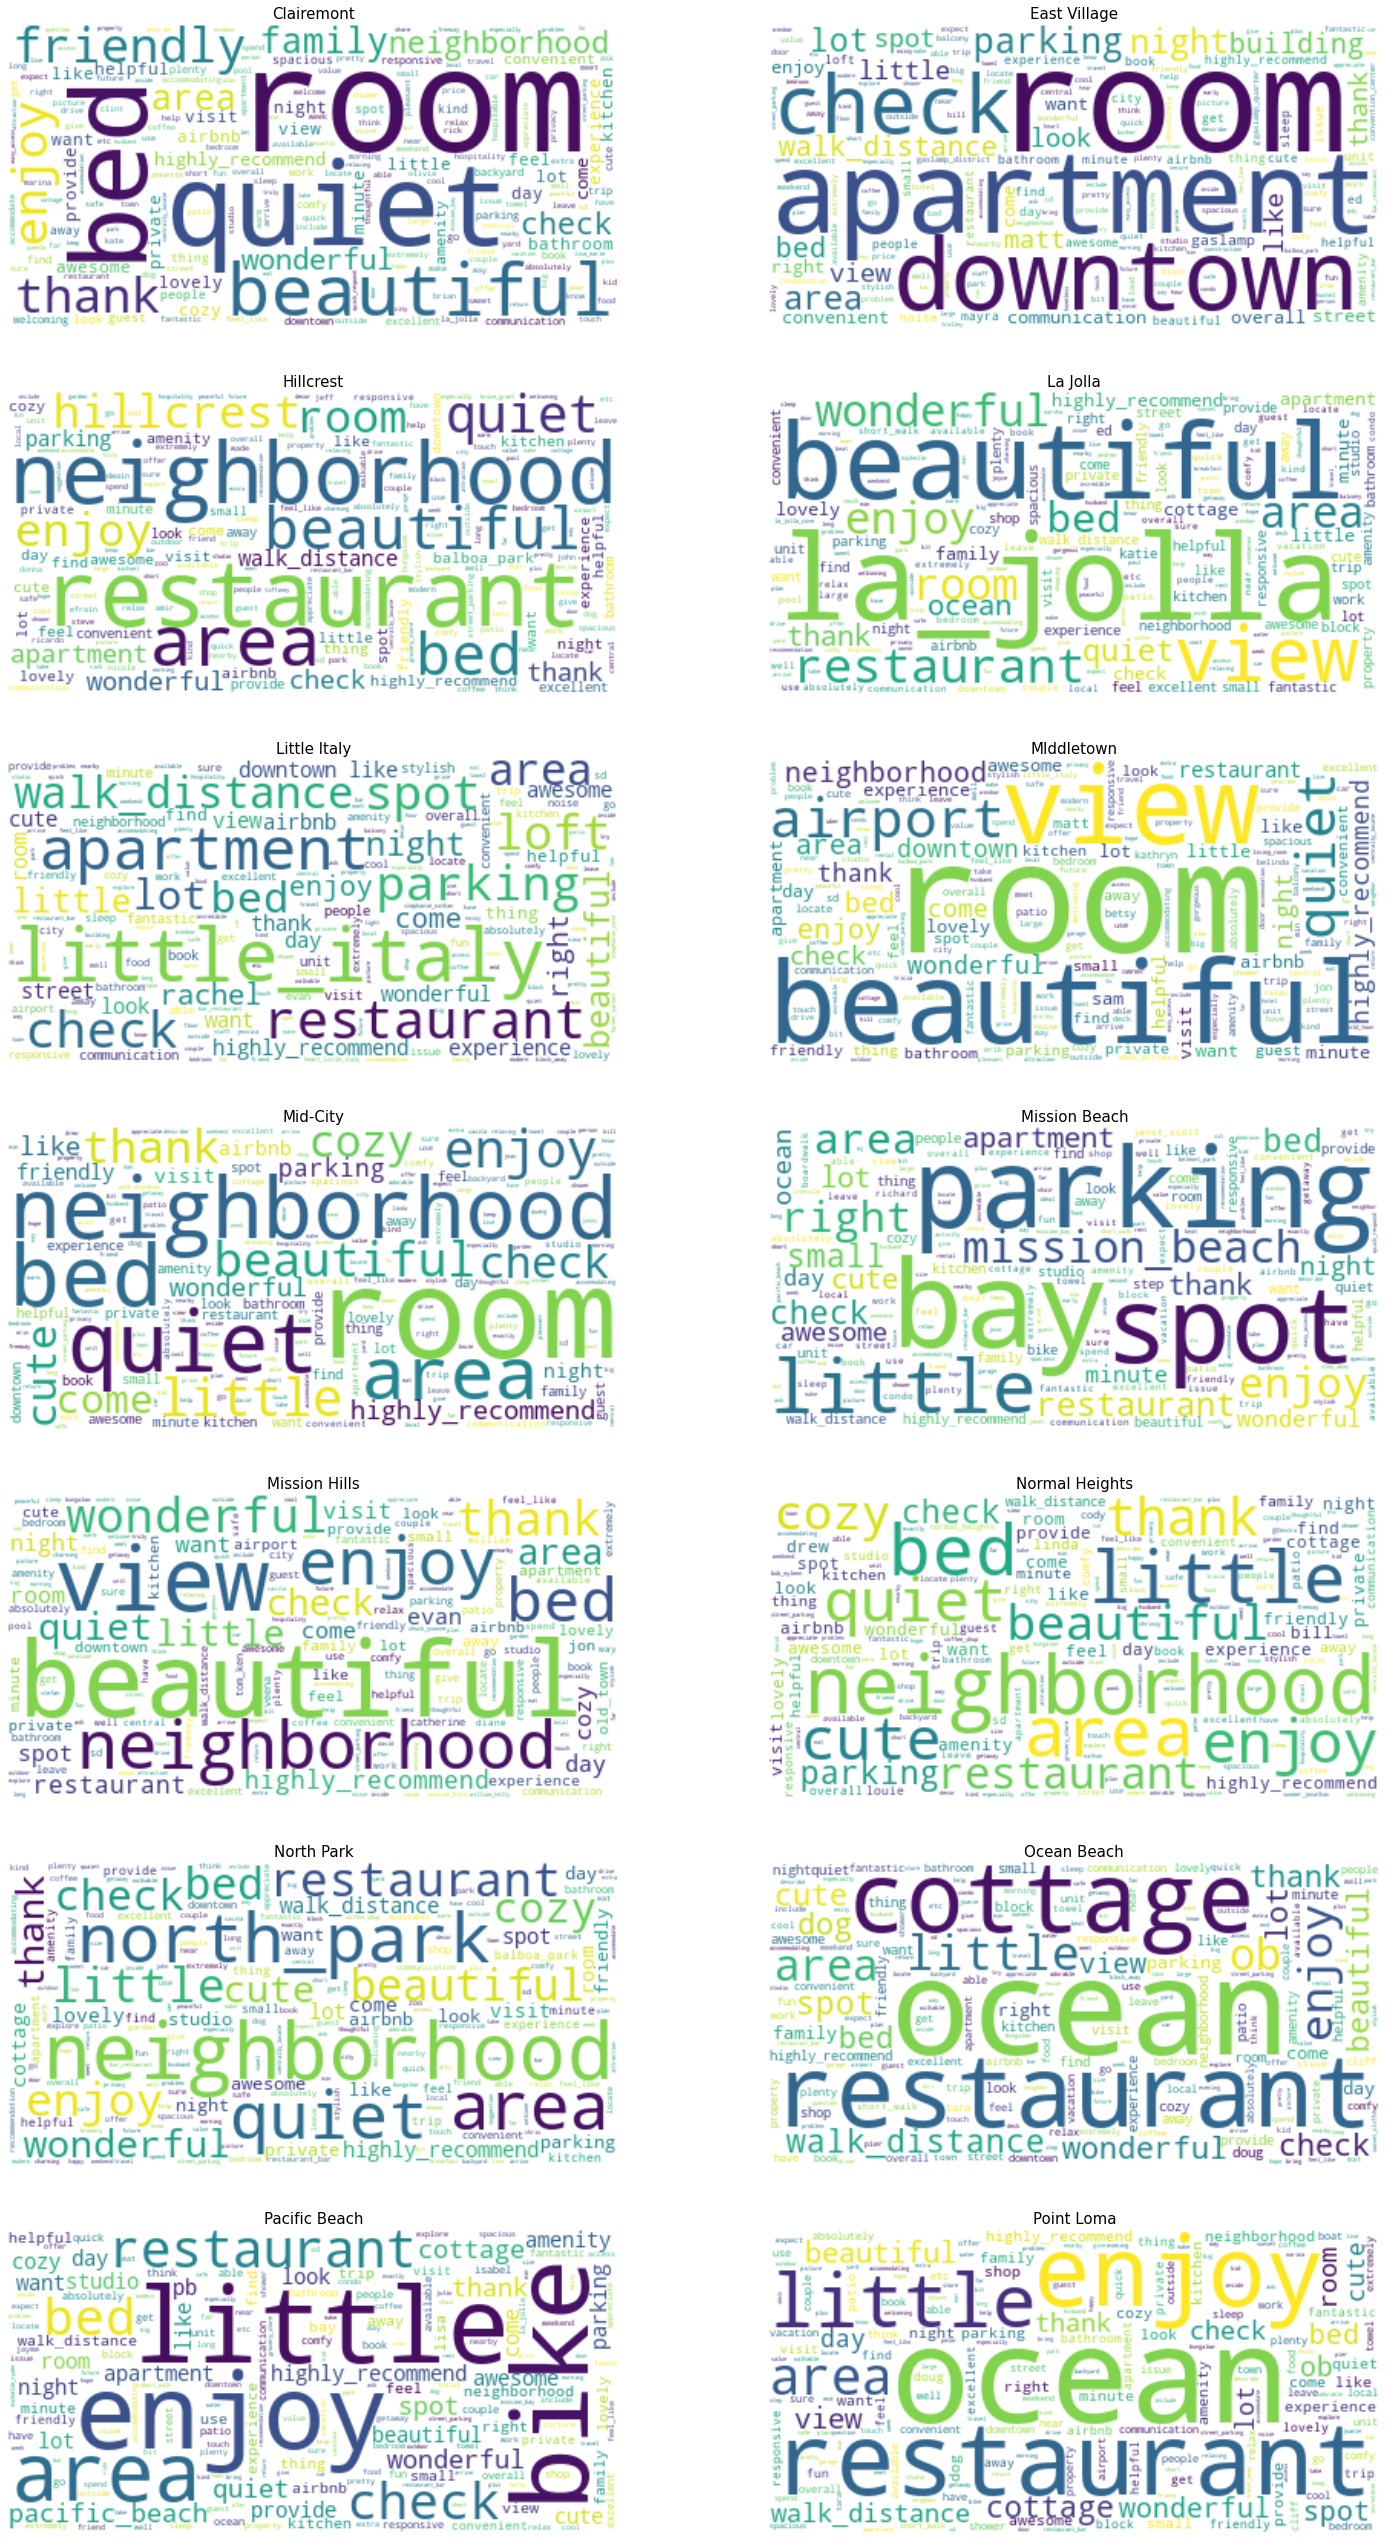

In [97]:
ncols = 2
nrows = math.ceil(len(neighborhoods) / ncols)
plt.figure(figsize=(25, 80))
neighborhoods_plot = {
    'Clairemont',
    'East Village',
    'Hillcrest',
    'La Jolla',
    'Little Italy',
    'MIddletown',
    'Mid-City',
    'Mission Beach',
    'Mission Hills',
    'Normal Heights',
    'North Park',
    'Ocean Beach',
    'Pacific Beach',
    'Point Loma'
}

for i, n in enumerate(sorted(neighborhoods_plot)):
    plt.subplot(nrows, ncols, i+1)
    word_cloud(word_counts[n], title=n, random_state=random_state)

In [26]:
word_counts_rating = {
    'high': Counter(word for doc in df[df.rating>3].comments_filter for word in doc),
    'low': Counter(word for doc in df[df.rating<=3].comments_filter for word in doc)
}

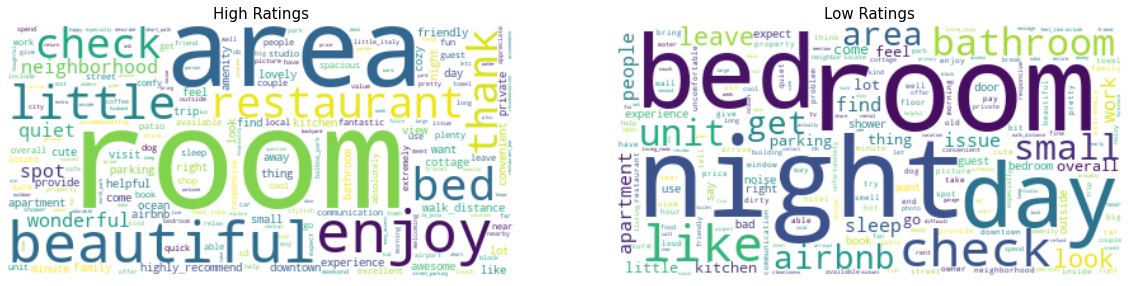

In [27]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
word_cloud(word_counts_rating['high'], title='High Ratings', random_state=random_state)
plt.subplot(1, 2, 2)
word_cloud(word_counts_rating['low'], title='Low Ratings', random_state=random_state)

# Topic Modeling

In [50]:
dic = Dictionary(df.comments_filter)

In [51]:
corpus = [dic.doc2bow(doc) for doc in df.comments_filter]

In [52]:
lda = LdaMulticore(corpus, num_topics=20, id2word=dic, passes=10, workers=4)

In [61]:
df['topics'] = [[topic[0] for topic in lda[doc]] for doc in corpus]

In [68]:
topic_counts = {n: Counter(topic for topic in df[df.neighborhood==n].topics.explode('topics')) for n in neighborhoods}

In [75]:
lda.print_topic(topic_counts['Pacific Beach'].most_common(1)[0][0])

'0.101*"restaurant" + 0.062*"walk_distance" + 0.039*"shop" + 0.031*"ocean" + 0.031*"lot" + 0.022*"local" + 0.020*"area" + 0.018*"block" + 0.017*"neighborhood" + 0.016*"food"'

In [80]:
lda.print_topic(topic_counts['Hillcrest'].most_common(1)[0][0])

'0.101*"restaurant" + 0.062*"walk_distance" + 0.039*"shop" + 0.031*"ocean" + 0.031*"lot" + 0.022*"local" + 0.020*"area" + 0.018*"block" + 0.017*"neighborhood" + 0.016*"food"'

In [79]:
lda.print_topic(topic_counts['East Village'].most_common(1)[0][0])

'0.084*"downtown" + 0.049*"minute" + 0.040*"away" + 0.039*"little_italy" + 0.035*"airport" + 0.024*"near" + 0.024*"min" + 0.022*"balboa_park" + 0.021*"area" + 0.020*"want"'